# 0. Load libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 16})

---
# 1. Look and analyse data

In [30]:
data = pd.read_csv('QA-DS-TASK-DATA-FROM-2020-REDUCED-COLUMNS.csv')
data.sample(5)

,Timestamp,Close Candle,Ticker Full Name
850565,2020-12-11 05:51:00,3643.00,E-MINI S&P 500 FUTURES
810667,2020-10-30 16:05:00,3271.50,E-MINI S&P 500 FUTURES
833736,2020-11-24 13:49:00,3631.75,E-MINI S&P 500 FUTURES
519334,2020-01-02 07:42:00,3249.25,E-MINI S&P 500 FUTURES
1734384,2021-11-03 05:53:00,15412.00,FTSE CHINA A50 INDEX FUTURES


In [31]:
data.describe(include='all')

,Timestamp,Close Candle,Ticker Full Name
count,1756857,1.756857e+06,1756857
unique,684436,NaN,3
top,2021-04-16 05:12:00,NaN,E-MINI S&P 500 FUTURES
freq,3,NaN,672899
mean,NaN,6.513649e+03,NaN
std,NaN,6.587486e+03,NaN
min,NaN,1.281560e+02,NaN
25%,NaN,1.391560e+02,NaN
50%,NaN,3.764250e+03,NaN
75%,NaN,1.391500e+04,NaN


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756857 entries, 0 to 1756856
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Timestamp         object 
 1   Close Candle      float64
 2   Ticker Full Name  object 
dtypes: float64(1), object(2)
memory usage: 40.2+ MB


In [33]:
# correct Timstamp column type
data['Timestamp'] = data['Timestamp'].astype('datetime64[ns]')

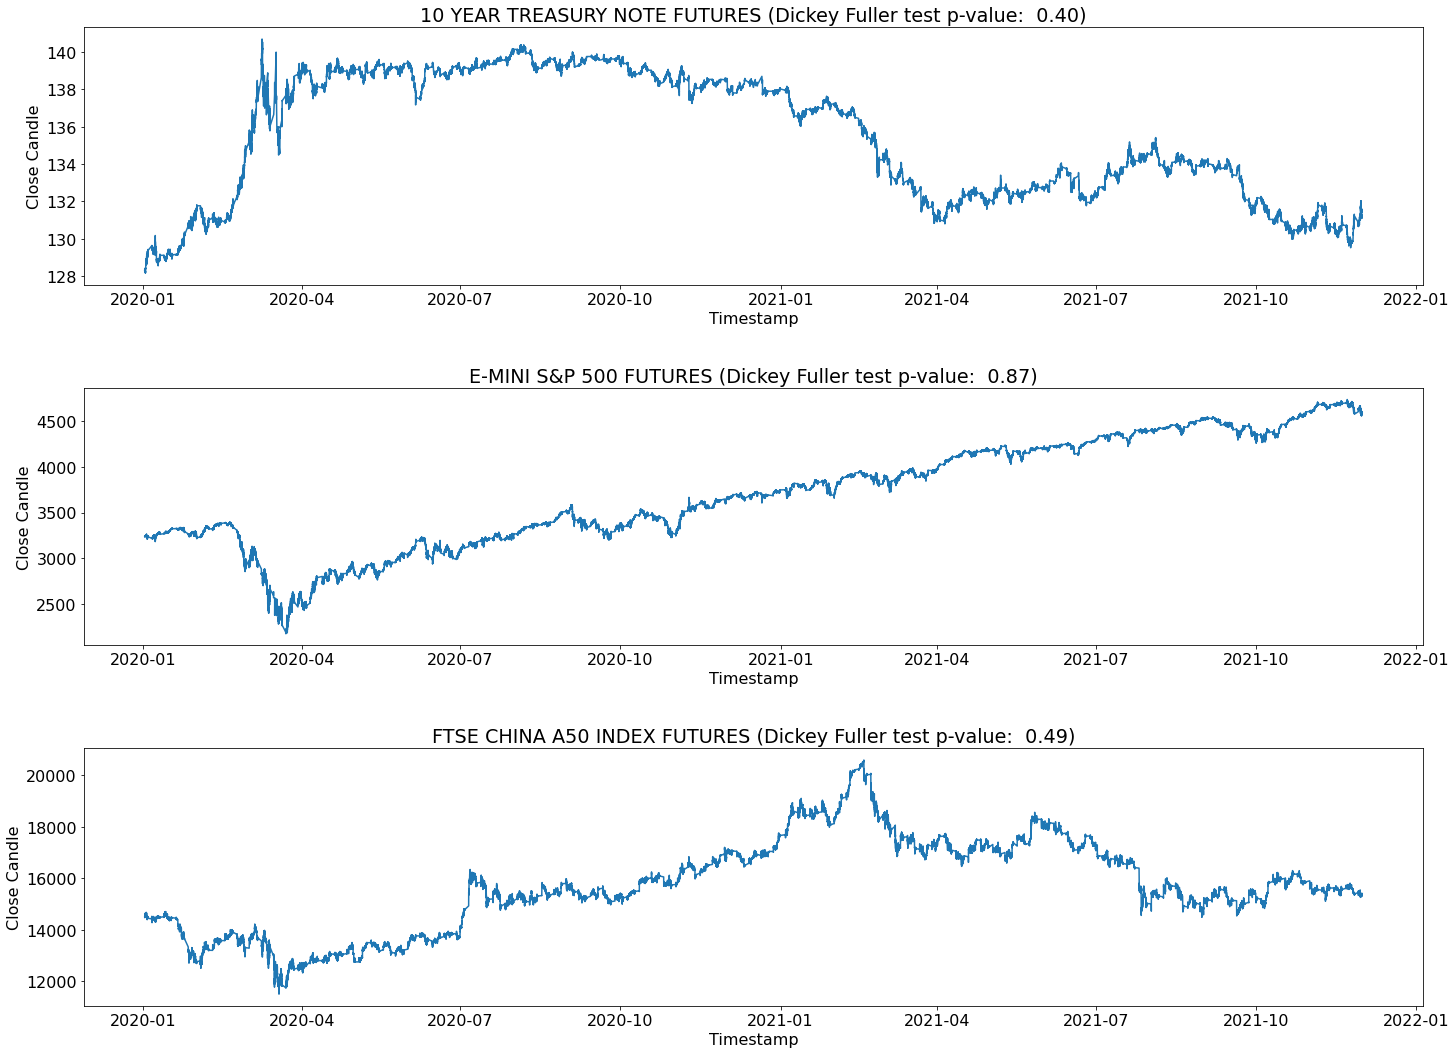

In [52]:
# Let's plot the graphs and use Dickey Fuller Test for stationary analysis
tickets = data['Ticker Full Name'].unique()

fig, ax = plt.subplots(nrows=len(tickets), ncols=1)
axes = ax.flatten()

for i in range(len(tickets)):
    # For Dickey Fuller test resample data up to days frequency to save the calculation time 
    stat_test = adfuller(data.loc[data['Ticker Full Name']==tickets[i], ['Timestamp', 'Close Candle']].set_index('Timestamp').resample('D').mean().dropna())
    axes[i].set_title(f'{tickets[i]} (Dickey Fuller test p-value: {stat_test[1]: .2f})')
    sns.lineplot(data=data.loc[data['Ticker Full Name']==tickets[i], :],
                x='Timestamp',
                y='Close Candle',
                ax=axes[i])
    
    print()
    
fig.set_size_inches(24, 6 * len(tickets))
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

- Well, time series under consideration are not stationary (see DF test and TS behaviour);
- There are no abnormal values (outliers);
- Some dependency can be noted relying on graph analysis: US treasures and S&P has controversal correlation (general situation), at the same time US and China indexes has positive correlation till the Feb of 2021 after that the trend of FTSE was changed.

In [35]:
data_df = pd.pivot_table(data, index='Timestamp', columns='Ticker Full Name', values='Close Candle')

In [36]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 684436 entries, 2020-01-01 18:01:00 to 2021-11-30 23:59:00
Data columns (total 3 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   10 YEAR TREASURY NOTE FUTURES  518515 non-null  float64
 1   E-MINI S&P 500 FUTURES         672899 non-null  float64
 2   FTSE CHINA A50 INDEX FUTURES   565443 non-null  float64
dtypes: float64(3)
memory usage: 20.9 MB


In [37]:
data_df = data_df.interpolate(method='linear', limit_area='inside')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 684436 entries, 2020-01-01 18:01:00 to 2021-11-30 23:59:00
Data columns (total 3 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   10 YEAR TREASURY NOTE FUTURES  684423 non-null  float64
 1   E-MINI S&P 500 FUTURES         684436 non-null  float64
 2   FTSE CHINA A50 INDEX FUTURES   684316 non-null  float64
dtypes: float64(3)
memory usage: 20.9 MB


---
# 2. Simulation of time series dependences

To find the denepdency between time series (TS) the next regression equation has been used (and see the picture below):
$$
Y_t = \sum a_i*Y^i_{t...t-n_i} + u_t
$$
, where $t$ - current time step, $Y$ - traget TS, $Y^i$ - influencing TS, $n_i$ - history time window for affected TS, $u_t$ - residuals  
$ $  
In order to find the dependency and lag-time between time series the next bullet-points has been taken into account:
- The characteristics of cointegration betwee TS is a stationary behaviour of residuals $u_t$. For estimation of $u_t$ stationarity Dickey-Fuller test has been used.
- The lag-window $t...t-n_i$ has been varied in different limits for each dependent TS.
- To estimate the delay degree initial TS has been researched in terms of minutes/hours and days, $i.e.$ regressions has been created for TS with a minute step, with an hour step and with a day step.
- Target and influenced time series has been rotated in the algorithm.$ $  

  
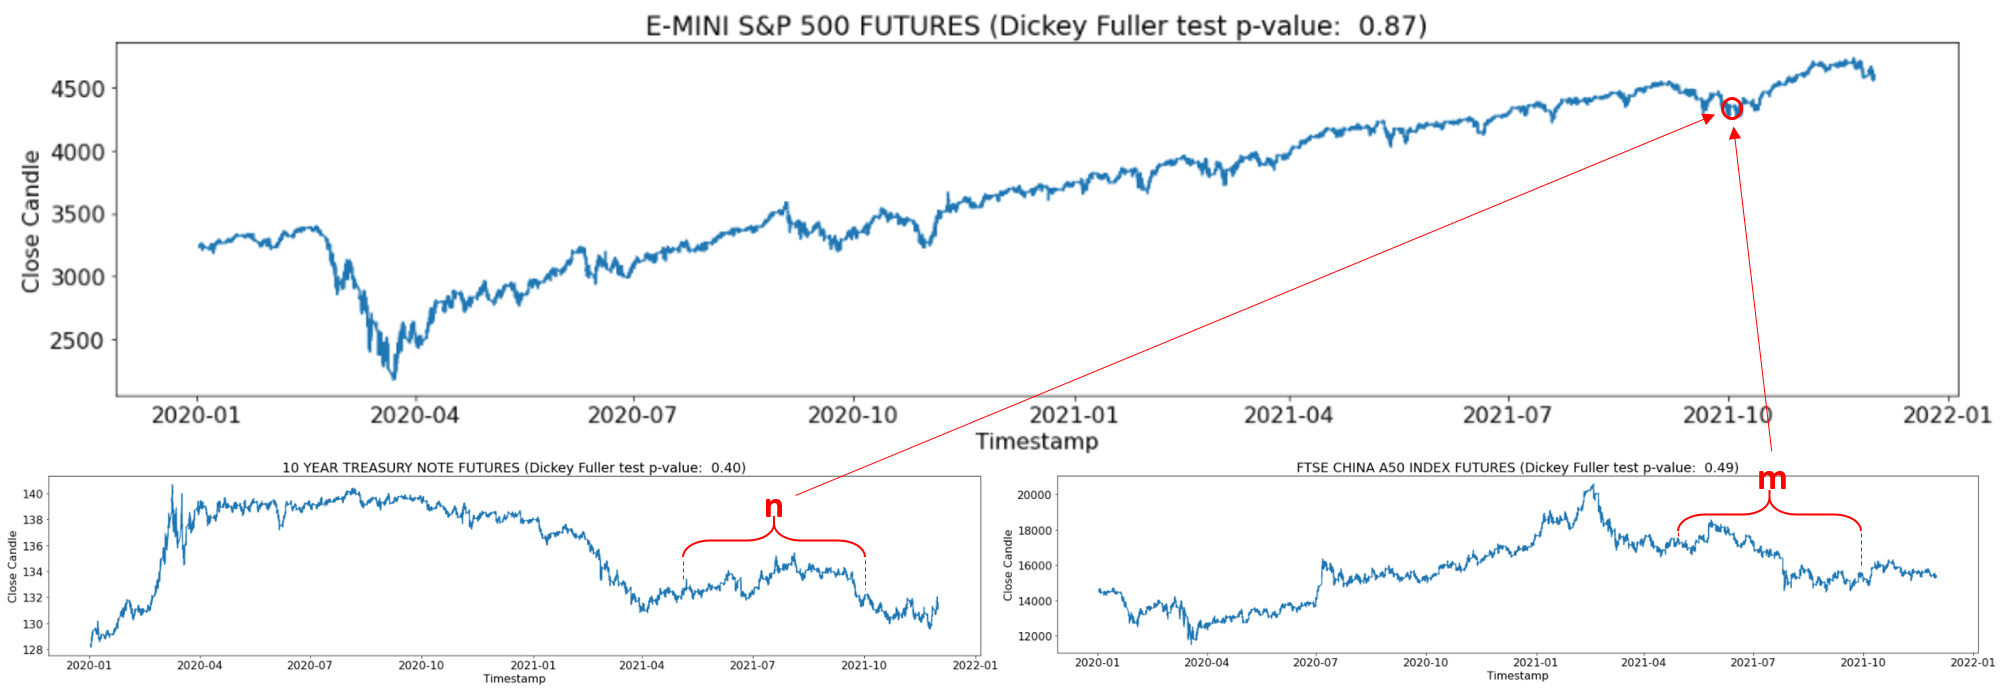

In [38]:
def data_shift(data: pd.DataFrame,
               columns: list,
               p: int) -> pd.DataFrame:
    """
    Function add new features as a time shift of p-order of selected time series (columns), i.e. p=2 means add feature with t-1 and t-2 shifts
    
    :param data:    Initial data frame with time series
    :param columns: Column for shift transform
    :param p:       Order of time shift
    
    :return:        Data Frame with new time shifted features
    """
    
    if p==0:
        return data
    df = data.copy()
    for column in columns:
        for t in range(p):
            df = pd.merge(df, df[[column]].shift(t+1).add_suffix(f'_t-{t+1}'), how='left', left_index=True, right_index=True)
    return df

In [39]:
def r2_adjusted(y_true: np.ndarray,
                y_predict: np.ndarray,
                n: int,
                p: int) -> float:
    """
    Calculate R2 with number of regressors correction
    
    :param y_true:    Array of true values
    :param y_predict: Array of predicted values
    :param n:         Number ofobservations
    :param p:         Number of regressors
    
    :return:          R2 adjusted score
    """
    r2_adj = 1 - (1 - r2_score(y_true, y_predict)) * (n - 1) / (n - p - 1)
    return r2_adj

In [40]:
# Normalize dataset
scaler = MinMaxScaler()
data_df[['E-MINI S&P 500 FUTURES',
         '10 YEAR TREASURY NOTE FUTURES',
         'FTSE CHINA A50 INDEX FUTURES']] = scaler.fit_transform(data_df[['E-MINI S&P 500 FUTURES',
                                                                          '10 YEAR TREASURY NOTE FUTURES',
                                                                          'FTSE CHINA A50 INDEX FUTURES']])

In [41]:
lr = LinearRegression()
# create data frame with simulation results
result = pd.DataFrame(columns=('resampling', 'target', 'col1', 'col2', 'col1_t', 'col2_t', 'params', 'r2', 'r2_adj', 'mae', 'mape', 'mae_valid', 'mape_valid', 'df_test'))

# Let's check short-term, mid-term and long-term correlation resampling dataset
resamplings = ['M', 'H', 'D']
# Fix lags of regressors as (n * step), e.g. from 0 up to (12 * 5 = 60)
n, step = 13, 5

with tqdm(total=100) as pbar:
    for resampling in resamplings:
        # rotate target and features
        for target in data_df.columns.values:

            cols = list(data_df.columns.values)
            cols.remove(target)
            col1, col2 = cols

            for t1 in range(n):
                for t2 in range(n):
                    df_experiment = data_df.copy()
                    
                    if resampling != 'M':
                        df_experiment = df_experiment.resample(resampling).mean().dropna()
                    
                    # create features by time shifting data
                    df_experiment = data_shift(df_experiment, [col1], step * t1)
                    df_experiment = data_shift(df_experiment, [col2], step * t2)
                    df_experiment.dropna(inplace=True)

                    X = df_experiment.drop(columns=(target))
                    y = df_experiment[target]

                    # split into train/valid datasets as 90%/10%
                    X_train, X_valid = X[:-len(X) // 10], X[-len(X) // 10:]
                    y_train, y_valid = y[:-len(X) // 10], y[-len(X) // 10:]
                    
                    model = lr.fit(X_train, y_train)
                    prediction_valid = model.predict(X_valid)
                    prediction_train = model.predict(X_train)
                    prediction = model.predict(X)
                    
                    result.loc[len(result)] = [resampling,
                                               target,
                                               col1,
                                               col2,
                                               step * t1,
                                               step * t2,
                                               np.append(model.coef_, model.intercept_),
                                               # Train metrics. R2 & R2_adjusted added to estimate the effectiveness of features adding
                                               r2_score(y_train, prediction_train),
                                               r2_adjusted(y_train, prediction_train, len(X_train), len(X_train.columns)),
                                               mean_absolute_error(y_train, prediction_train),
                                               mean_absolute_percentage_error(y_train, prediction_train),
                                               # Validation metrics
                                               mean_absolute_error(y_valid, prediction_valid),
                                               mean_absolute_percentage_error(y_valid, prediction_valid),
                                               # Stationary test for whole time series.
                                               #To save calculation time resamle minutes dataframe into hours dataframe for ADF test (otherwise if will take looooong time for calculation)
                                               adfuller((y-prediction).resample('H').mean().dropna())[1] if resampling=='M' else adfuller(y-prediction)[1],
                                              ]

                    pbar.update(100 / (len(data_df.columns.values) * len(resamplings) * n**2) )

100%|█████████▉| 99.99999999999639/100 [1:48:23<00:00, 65.03s/it]     


In [42]:
result.describe()

,r2,r2_adj,mae,mape,mae_valid,mape_valid,df_test
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000
mean,0.552650,0.536249,0.113061,inf,0.189153,0.445269,0.356828
std,0.138687,0.129196,0.031715,NaN,0.075280,0.283933,0.233646
min,0.329028,0.326524,0.080492,0.148385,0.069046,0.077763,0.001126
25%,0.513905,0.454564,0.088729,0.277041,0.093166,0.258395,0.026388
50%,0.550321,0.520748,0.106987,0.320758,0.227018,0.363418,0.474139
75%,0.642644,0.640088,0.116400,NaN,0.238265,0.513678,0.539858
max,0.815783,0.772895,0.171138,inf,0.373353,1.803964,0.755177


In [43]:
# select results with passed ADF test with 5% error and restrict MAPE
result.loc[(result['df_test']<=0.05) & (result['mape_valid']<=0.1), :]

,resampling,target,col1,col2,col1_t,col2_t,params,r2,r2_adj,mae,mape,mae_valid,mape_valid,df_test
1330,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,20,"[-0.38138462141863344, 0.29959425549422314, 0....",0.746969,0.699564,0.083994,0.287751,0.079507,0.084207,0.043127


The result showed that S&P followed by Treasury and FTSE with 55 and 20 days delay respectively

0.7838265394330857 0.7481068903694539 0.2671718114495169 0.08420674078745896 0.043127374959129806


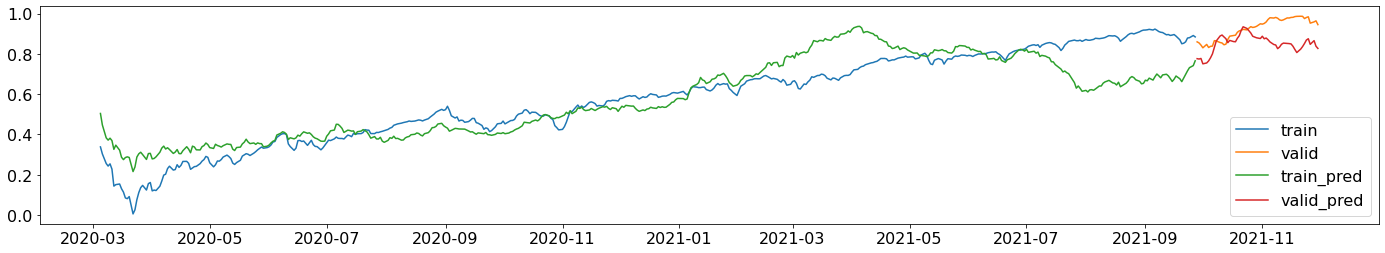

Wall time: 221 ms


In [53]:
%%time
# The best iteration
df_experiment = data_df.copy()
df_experiment = df_experiment.resample('D').mean().dropna()
df_experiment = data_shift(df_experiment, ['10 YEAR TREASURY NOTE FUTURES'], 55)
df_experiment = data_shift(df_experiment, ['FTSE CHINA A50 INDEX FUTURES'], 20)
df_experiment.dropna(inplace=True)

# df_experiment = sqr_sqrt_log_features_transform(df_experiment)
X = df_experiment.drop(columns=('E-MINI S&P 500 FUTURES'))
y = df_experiment['E-MINI S&P 500 FUTURES']

# split into train/valid datasets 
X_train, X_valid = X[:-len(X) // 10], X[-len(X) // 10:]
y_train, y_valid = y[:-len(X) // 10], y[-len(X) // 10:]

model = lr.fit(X_train, y_train)
prediction = model.predict(X_valid)

print(r2_score(y.values, model.predict(X)),
      r2_adjusted(y.values, model.predict(X), len(X), len(X.columns)),
      mean_absolute_percentage_error(y.values, model.predict(X)),
      mean_absolute_percentage_error(y_valid.values, model.predict(X_valid)),
      adfuller((y-model.predict(X)).resample('H').mean().dropna())[1])
plt.figure(figsize=(24, 4))
plt.plot(y_train, label='train')
plt.plot(y_valid, label='valid')
plt.plot(y_train.index, model.predict(X_train), label='train_pred')
plt.plot(y_valid.index, prediction, label='valid_pred')
plt.legend()
plt.show()

### Data Separation
There is a change of FTSE Time Series trend around the date 2021-02-17, let's try to separate the time series at this date and use only last part of its.

In [45]:
lr = LinearRegression()
result_separated = pd.DataFrame(columns=('resampling', 'target', 'col1', 'col2', 'col1_t', 'col2_t', 'params', 'r2', 'r2_adj', 'mae', 'mape', 'mae_valid', 'mape_valid', 'df_test'))

# Let's check short-term, mid-term and long-term correlation resampling dataset
resamplings = ['M', 'H', 'D']
# Fix lags of regressors as (n * step), e.g. from 0 up to (12 * 5 = 60)
n, step = 13, 5

with tqdm(total=100) as pbar:
    for resampling in resamplings:
        for target in data_df.columns.values:

            cols = list(data_df.columns.values)
            cols.remove(target)
            col1, col2 = cols

            for t1 in range(n):
                for t2 in range(n):
                    df_experiment = data_df.loc[data_df.index>='2021-02-17', :]
                    
                    if resampling != 'M':
                        df_experiment = df_experiment.resample(resampling).mean().dropna()
                        
                    df_experiment = data_shift(df_experiment, [col1], step * t1)
                    df_experiment = data_shift(df_experiment, [col2], step * t2)
                    df_experiment.dropna(inplace=True)

                    X = df_experiment.drop(columns=(target))
                    y = df_experiment[target]

                    # split into train/valid datasets as 90%/10%
                    X_train, X_valid = X[:-len(X) // 10], X[-len(X) // 10:]
                    y_train, y_valid = y[:-len(X) // 10], y[-len(X) // 10:]
                    
                    model = lr.fit(X_train, y_train)
                    prediction_valid = model.predict(X_valid)
                    prediction_train = model.predict(X_train)
                    prediction = model.predict(X)
                    
                    result_separated.loc[len(result_separated)] = [resampling,
                                                                   target,
                                                                   col1,
                                                                   col2,
                                                                   step * t1,
                                                                   step * t2,
                                                                   np.append(model.coef_, model.intercept_),
                                                                   # Train metrics. R2 & R2_adjusted added to estimate the effectiveness of features adding
                                                                   r2_score(y_train, prediction_train),
                                                                   r2_adjusted(y_train, prediction_train, len(X_train), len(X_train.columns)),
                                                                   mean_absolute_error(y_train, prediction_train),
                                                                   mean_absolute_percentage_error(y_train, prediction_train),
                                                                   # Validation metrics
                                                                   mean_absolute_error(y_valid, prediction_valid),
                                                                   mean_absolute_percentage_error(y_valid, prediction_valid),
                                                                   # Stationary test for whole time series.
                                                                   #To save calculation time resamle minutes dataframe into hours dataframe for ADF test (otherwise if will take looooong time for calculation)
                                                                   adfuller((y-prediction).resample('H').mean().dropna())[1] if resampling=='M' else adfuller(y-prediction)[1],
                                                                  ]

                    pbar.update(100 / (len(data_df.columns.values) * len(resamplings) * n**2) )

100%|█████████▉| 99.99999999999639/100 [43:13<00:00, 25.93s/it]    


In [46]:
result_separated.describe()

,r2,r2_adj,mae,mape,mae_valid,mape_valid,df_test
count,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1521.000000,1.521000e+03
mean,0.524656,0.484183,0.051978,0.116396,0.119942,0.440197,1.609360e-01
std,0.291025,0.273284,0.020268,0.077426,0.067964,0.470412,2.533988e-01
min,0.003872,-0.005266,0.007569,0.011027,0.020703,0.021402,2.336832e-10
25%,0.435106,0.247264,0.039175,0.051724,0.074810,0.103167,7.051188e-03
50%,0.605283,0.602059,0.050691,0.110944,0.099630,0.168888,7.022988e-02
75%,0.687728,0.619605,0.065179,0.175697,0.160108,0.871978,1.202749e-01
max,0.990118,0.962719,0.082047,0.248258,0.390328,2.121765,9.986326e-01


In [47]:
# The result is better, so in addition to ADF test and MAPE restriction add R2 score restriction
result_separated.loc[(result_separated['df_test']<=0.05) & (result_separated['mape_valid']<=0.05) & (result_separated['r2_adj']>=0.7), :]

,resampling,target,col1,col2,col1_t,col2_t,params,r2,r2_adj,mae,mape,mae_valid,mape_valid,df_test
1326,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,0,"[0.061695123278422546, -0.5116688103592679, -0...",0.805129,0.706831,0.018993,0.022311,0.044557,0.045559,0.001251
1327,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,5,"[0.11404657049317561, -0.23383954631574588, -0...",0.827848,0.729020,0.017603,0.020723,0.036996,0.037951,0.006379
1328,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,10,"[0.1099630819601857, -0.23329326779085846, -0....",0.830800,0.720737,0.017582,0.020741,0.035486,0.036447,0.008052
1329,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,15,"[0.10150648136495619, -0.24042342977739933, -0...",0.832830,0.710011,0.017668,0.020870,0.034232,0.035170,0.010683
1330,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,20,"[-0.007224720508797045, -0.32693633781371084, ...",0.845494,0.717569,0.016945,0.019999,0.030985,0.031851,0.003238
1331,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,55,25,"[-0.01841729465265017, -0.306679612035281, -0....",0.849830,0.709898,0.016631,0.019626,0.028057,0.028873,0.005489
1339,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,60,0,"[0.015973647850203963, -0.5425027974994446, 0....",0.825476,0.721432,0.018464,0.021792,0.034669,0.035535,0.000851
1340,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,60,5,"[0.05644301379532925, -0.2721430344471487, 0.0...",0.856003,0.758550,0.016553,0.019566,0.025153,0.025950,0.002965
1341,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,60,10,"[0.04708771838173421, -0.2625081692970499, -0....",0.866995,0.765119,0.015709,0.018646,0.022487,0.023314,0.007329
1342,D,E-MINI S&P 500 FUTURES,10 YEAR TREASURY NOTE FUTURES,FTSE CHINA A50 INDEX FUTURES,60,15,"[0.019923668795738484, -0.27940977559962576, -...",0.872320,0.761856,0.015659,0.018619,0.020951,0.021803,0.029356


Modelling with devided data showed that S&P followed by Treasury and FTSE with 55-60 and 0-25 days delay respectively. The average time shift is 57 for US Treasury TS and 11 for China FTSE TS.

0.8694468588938397 0.7920000802715411 0.02136889753333977 0.02902281925327746 0.002492248728604767


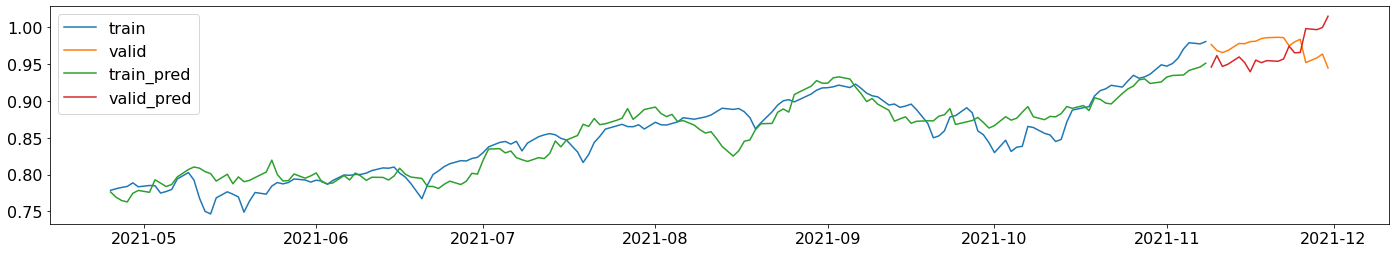

Wall time: 193 ms


In [55]:
%%time
# One of the best iteration (the least MAPE)
from sklearn.metrics import mean_squared_error

df_experiment = data_df.loc[data_df.index>='2021-02-17', :]
df_experiment = df_experiment.resample('D').mean().dropna()
df_experiment = data_shift(df_experiment, ['10 YEAR TREASURY NOTE FUTURES'], 57)
df_experiment = data_shift(df_experiment, ['FTSE CHINA A50 INDEX FUTURES'], 11)
df_experiment.dropna(inplace=True)

X = df_experiment.drop(columns=('E-MINI S&P 500 FUTURES'))
y = df_experiment['E-MINI S&P 500 FUTURES']

# split into train/valid datasets 
X_train, X_valid = X[:-len(X) // 10], X[-len(X) // 10:]
y_train, y_valid = y[:-len(X) // 10], y[-len(X) // 10:]

model = lr.fit(X_train, y_train)
prediction = model.predict(X_valid)

print(r2_score(y.values, model.predict(X)),
      r2_adjusted(y.values, model.predict(X), len(X), len(X.columns)),
      mean_absolute_percentage_error(y.values, model.predict(X)),
      mean_absolute_percentage_error(y_valid.values, model.predict(X_valid)),
      adfuller((y-model.predict(X)).resample('H').mean().dropna())[1])

plt.figure(figsize=(24, 4))
plt.plot(y_train, label='train')
plt.plot(y_valid, label='valid')
plt.plot(y_train.index, model.predict(X_train), label='train_pred')
plt.plot(y_valid.index, prediction, label='valid_pred')
plt.legend()
plt.show()

---
# 3. Summary
- The result showed that time series have correlation between each other (there is a regression when residual is stationary);
- The trend of China FTSE has been changed in 2021-02-17 as well as US Tresury has some change near that date;
- The change in S&P TS appears after change in US Treasury (in average 57 days) and in China FTSE (in average 11 days).